In [1]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

# Прогружаем данные

In [6]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1
    df = df.resample("1d").mean()
    df.fillna(method="ffill", inplace=True)

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.adjclose.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green', fontsize=9);
    plt.yscale('log')

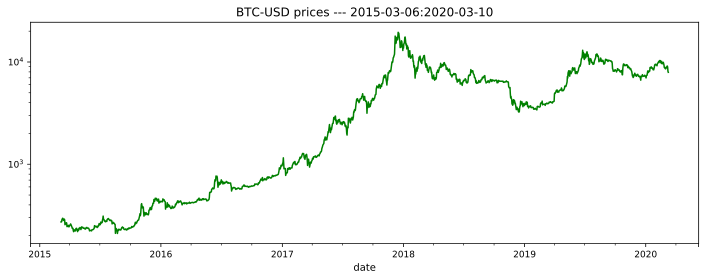

In [70]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-03-06', 
                  end_date='2020-03-10', 
                  freq='daily', 
                  path='data/BTC.csv')

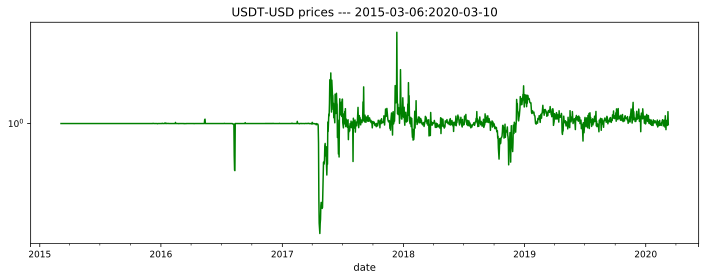

In [71]:
download_csv_data(ticker='USDT-USD', 
                  start_date='2015-03-06', 
                  end_date='2020-03-10', 
                  freq='daily', 
                  path='data/USDT.csv')

In [167]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'USDT']

In [168]:
# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
        
COLUMNS = ['open', 'close']

                  open       close
date                              
2015-03-06  272.722992  272.722992
2015-03-07  276.260986  276.260986
2015-03-08  274.354004  274.354004
2015-03-09  289.606995  289.606995
2015-03-10  291.760010  291.760010
            open  close
date                   
2015-03-06   1.0    1.0
2015-03-07   1.0    1.0
2015-03-08   1.0    1.0
2015-03-09   1.0    1.0
2015-03-10   1.0    1.0


In [169]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1831 (major_axis) x 2 (minor_axis)
Items axis: BTC to USDT
Major_axis axis: 2015-03-06 00:00:00+00:00 to 2020-03-09 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [170]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr(method='pearson')

,BTC,USDT
BTC,1.000000,0.182053
USDT,0.182053,1.000000


In [171]:
data_corr.corr(method='kendall')

,BTC,USDT
BTC,1.000000,0.196269
USDT,0.196269,1.000000


In [172]:
data_corr.corr(method='spearman')

,BTC,USDT
BTC,1.000000,0.296284
USDT,0.296284,1.000000


In [173]:
data_corr.corr(method='pearson').values[0][1]

0.18205283261965505

In [163]:
corr_list = []
corr_list.append(data_corr.corr(method='pearson').values[0][1])

In [164]:
data_corr.head(10)

,BTC,USDT
date,,
2015-03-06,272.722992,1.0
2015-03-07,276.260986,1.0
2015-03-08,274.354004,1.0
2015-03-09,289.606995,1.0
2015-03-10,291.760010,1.0
2015-03-11,296.378998,1.0
2015-03-12,294.354004,1.0
2015-03-13,285.337006,1.0
2015-03-14,281.885010,1.0


# Анализ лага корреляции

In [165]:
for shift in tqdm(range(0, 100)):
    data_corr.BTC = data_corr.BTC.shift(1)
    data_corr.dropna()
    corr_list.append(data_corr.corr(method='pearson').values[0][1])

100%|██████████| 100/100 [00:00<00:00, 746.25it/s]


In [166]:
corr_list

[0.18205283261965505,
 0.1796125246442395,
 0.1786820122915682,
 0.18042670204102257,
 0.18256245516976724,
 0.1841530996657254,
 0.18123957176928693,
 0.17630678575373357,
 0.1740477359404412,
 0.17233732959462525,
 0.17144163567111292,
 0.1715094931111676,
 0.16742324620073396,
 0.16320231873663182,
 0.16131924312370333,
 0.15924032198482896,
 0.15801556503029135,
 0.15344921483419965,
 0.15042765910384967,
 0.1493073249907155,
 0.14789577320240455,
 0.14796741648315903,
 0.14631003640179957,
 0.14365930142658878,
 0.14025335885873808,
 0.13789874707290184,
 0.1384370360626343,
 0.13772970551938268,
 0.13688021954917867,
 0.13719002897164523,
 0.13592611983986685,
 0.13633159449744797,
 0.13566045168307597,
 0.135749145835761,
 0.13397324258029955,
 0.13267887452597973,
 0.13199143803336483,
 0.1315341593590709,
 0.1301229428838038,
 0.12821272255248567,
 0.12674310527864194,
 0.1236788403817742,
 0.12141734480106198,
 0.11852611863006214,
 0.11704017740894314,
 0.11681244424787124,


In [174]:
neg_corr_list = []
for shift in tqdm(range(0, 100)):
    data_corr.BTC = data_corr.BTC.shift(-1)
    data_corr.dropna()
    neg_corr_list.append(data_corr.corr(method='pearson').values[0][1])

100%|██████████| 100/100 [00:00<00:00, 835.72it/s]


In [175]:
neg_corr_list

[0.1812300482783633,
 0.18124186847769,
 0.18520958982922586,
 0.18806484390775685,
 0.18789028222140342,
 0.18842539364407818,
 0.18563542309918818,
 0.18476728323656358,
 0.18363449951128535,
 0.18255906852997517,
 0.18429150789752105,
 0.18208906934428104,
 0.1805531002965705,
 0.1805008792180902,
 0.17748426226415392,
 0.1741374269266557,
 0.17123162682021936,
 0.16912141740180106,
 0.17022361409008963,
 0.16974807330596414,
 0.17118175645107203,
 0.17181855185154335,
 0.17293675099285097,
 0.17391070543479914,
 0.17554963398696632,
 0.17531991645915823,
 0.17419998503335912,
 0.17498579480119641,
 0.1756248041528071,
 0.17335041178886915,
 0.17411877898366085,
 0.17460442368921428,
 0.17477862002245498,
 0.17484079608957862,
 0.1718252778505727,
 0.17135595242160234,
 0.17096961573055125,
 0.1708027645483273,
 0.17009625737368314,
 0.16867954630254592,
 0.16810281451877299,
 0.1682670335184253,
 0.16815012912061003,
 0.16873700172375491,
 0.16932967817505024,
 0.16926353408985972,

In [176]:
neg_corr_list.reverse()

In [177]:
neg_corr_list

[0.19185468382974075,
 0.1925254366702115,
 0.192486098344369,
 0.192477224434817,
 0.1918155477045416,
 0.19216033770565816,
 0.191811792307443,
 0.19164504179627767,
 0.19109666939624328,
 0.19123487391898203,
 0.1909974294078595,
 0.192548004067107,
 0.1923517849167903,
 0.1940049719217653,
 0.19443634499814308,
 0.19499442971812192,
 0.1960686210914071,
 0.19646358702161645,
 0.19706855701252746,
 0.19711687898805627,
 0.1972049048837129,
 0.1971190990394311,
 0.19720599222715582,
 0.1952830657614874,
 0.19554883986497934,
 0.19373203653728277,
 0.1933280652432286,
 0.19344301463642263,
 0.19206071153310164,
 0.19238336527588049,
 0.1920568195421046,
 0.18995494742475702,
 0.1884048033540109,
 0.18864585541734485,
 0.18733083576602264,
 0.1865557343139653,
 0.1856520022274343,
 0.18326264972629308,
 0.18132501663231093,
 0.17894724778052568,
 0.17836818486370107,
 0.17792931556970779,
 0.17619001268084628,
 0.17458427096970336,
 0.17487359009930362,
 0.17373635146636435,
 0.1730243

In [178]:
final_list = neg_corr_list + corr_list

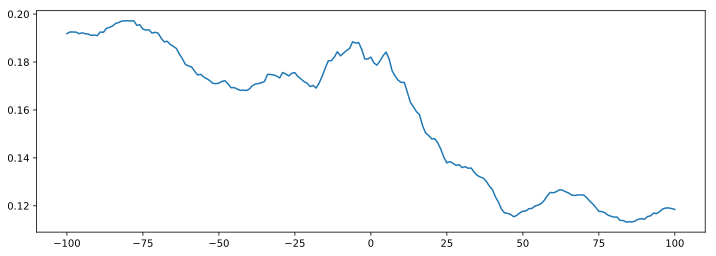

In [183]:
xlist = range(-100, 101)
ylist = final_list
plt.plot(xlist, ylist)
plt.show()

In [193]:
trend = pd.read_csv('data/trends.csv', sep=";", index_col = 'date')

In [194]:
trend.head()

,value
date,
2015-03-15,2
2015-03-22,2
2015-03-29,2
2015-04-05,2
2015-04-12,2


In [195]:
trend.tail()

,value
date,
2020-02-09,13
2020-02-16,11
2020-02-23,11
2020-03-01,11
2020-03-08,14


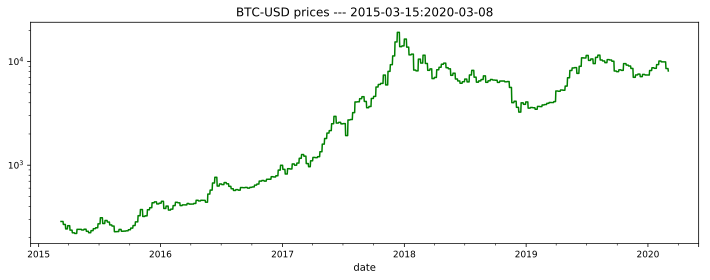

In [197]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-03-15', 
                  end_date='2020-03-08', 
                  freq='weekly', 
                  path='data/BTC.csv')